Celem laboratorium jest zapoznanie się ze sposobem przeprowadzania testów statystycznych w języku Python.

Zbiór danych:

·        Penguins (seaborn.load_dataset('penguins'))

·        winequality-red.csv (https://archive.ics.uci.edu/dataset/186/wine+quality)

In [1]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets


Eksploracja i wstępne przetwarzanie

a.      Wczytaj dane, wypełnij braki w danych

b.      Opisz zmienne: typy, podstawowe statystyki, korelacje (Pearson/Spearman).

c.      Zwizualizuj rozkład 2 wybranych cech ciągłych (hist + KDE) per kategoria (np. species).

d.      Sprawdź normalność dla wybranej cechy w 2 grupach (Shapiro lub D’Agostino).

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB
None
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      333.000000     333.000000         333.000000   333.000000
mean        43.992793      17.164865         200.966967  4207.057057
std          5.468668       1.969235          14.015765   805.215802
min         32.100000      13.100000         172.000000  2700.000000
25%         39.500000      15.600000         190.000000  3550.0000

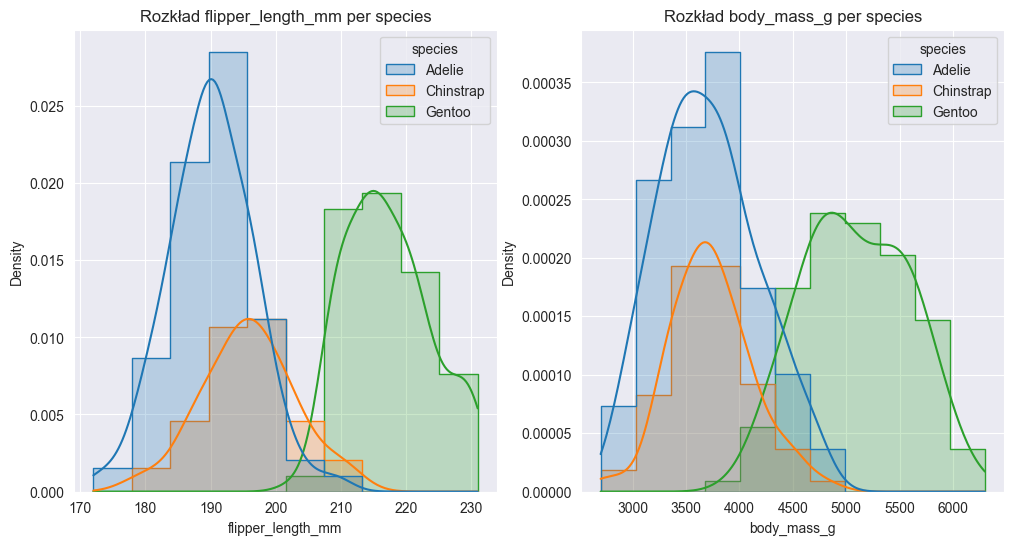

Shapiro-Wilk test for Adelie: stat=0.9811607743342855, p=0.04232240463471649
Shapiro-Wilk test for Chinstrap: stat=0.984493761674102, p=0.5605082387697975


In [2]:
# 1.a Wczytaj dane, wypełnij braki w danych
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins.isnull().sum()

# 1.b Opisz zmienne: typy, podstawowe statystyki, korelacje (Pearson/Spearman).
print(penguins.info())
print(penguins.describe())
print(penguins.corr(method='pearson', numeric_only=True))
print(penguins.corr(method='spearman', numeric_only=True))

# 1.c Zwizualizuj rozkład 2 wybranych cech ciągłych (hist + KDE) per kategoria (np. species).

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=penguins, x='flipper_length_mm', hue='species',
                kde=True, element='step', stat='density')
plt.title('Rozkład flipper_length_mm per species')
plt.subplot(1, 2, 2)
sns.histplot(data=penguins, x='body_mass_g', hue='species',
                kde=True, element='step', stat='density')
plt.title('Rozkład body_mass_g per species')
plt.show()

# 1.d Sprawdź normalność dla wybranej cechy w 2 grupach (Shapiro lub D’Agostino).

group1 = penguins[penguins['species'] == 'Adelie']['body_mass_g']
group2 = penguins[penguins['species'] == 'Chinstrap']['body_mass_g']
stat1, p1 = shapiro(group1)
stat2, p2 = shapiro(group2)
print(f'Shapiro-Wilk test for Adelie: stat={stat1}, p={p1}')
print(f'Shapiro-Wilk test for Chinstrap: stat={stat2}, p={p2}')

 Estymacja i testy statystyczne

a.      Zbuduj 95% CI dla średnije wybranych cech w każdej grupie (parametrycznie i bootstrap 5K próbek)

b.      Porównaj dwie grupy: t-test Welch’a lub Mann-Whitney (dobór testu)

c.      Dla >=3 grup: ANOVA lub Kruskal-Wallis

d.      Testy proporcji: porównaj odsetek braków/warunku między dwiema grupami (test z dla proporcji, CI Wilsona).

In [3]:
#a. Zbuduj 95% CI dla średnije wybranych cech w każdej grupie (parametrycznie i bootstrap 5K próbek)

def bootstrap_ci(data, n_bootstrap=5000, ci=95):
    boot_means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower, upper

for species in penguins['species'].unique():
    group = penguins[penguins['species'] == species]['body_mass_g']
    mean = np.mean(group)
    sem = stats.sem(group)
    ci_parametric = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    ci_bootstrap = bootstrap_ci(group)
    print(f'{species} - Mean: {mean}, Parametric CI: {ci_parametric}, Bootstrap CI: {ci_bootstrap}')
#b. Porównaj dwie grupy: t-test Welch’a lub Mann-Whitney (dobór testu)

group1 = penguins[penguins['species'] == 'Adelie']['body_mass_g']
group2 = penguins[penguins['species'] == 'Chinstrap']['body_mass_g']
stat, p = ttest_ind(group1, group2, equal_var=False)
print(f'T-test Welch\'s: stat={stat}, p={p}')
stat, p = mannwhitneyu(group1, group2)
print(f'Mann-Whitney U: stat={stat}, p={p}')
#c. Dla >=3 grup: ANOVA lub Kruskal-Wallis

group1 = penguins[penguins['species'] == 'Adelie']['body_mass_g']
group2 = penguins[penguins['species'] == 'Chinstrap']['body_mass_g']
group3 = penguins[penguins['species'] == 'Gentoo']['body_mass_g']
stat, p = f_oneway(group1, group2, group3)
print(f'ANOVA: stat={stat}, p={p}')
stat, p = kruskal(group1, group2, group3)
print(f'Kruskal-Wallis: stat={stat}, p={p}')
#d. Testy proporcji: porównaj odsetek braków/warunku między dwiema grupami (test z dla proporcji, CI Wilsona).

# Dodajmy sztuczne braki do danych
penguins_with_nans = sns.load_dataset('penguins')
penguins_with_nans.loc[penguins_with_nans.sample(frac=0.1).index, 'body_mass_g'] = np.nan
group1 = penguins_with_nans[penguins_with_nans['species'] == 'Adelie']
group2 = penguins_with_nans[penguins_with_nans['species'] == 'Chinstrap']
count = np.array([group1['body_mass_g'].isnull().sum(), group2['body_mass_g'].isnull().sum()])
nobs = np.array([len(group1), len(group2)])
stat, p = proportions_ztest(count, nobs)
ci1 = proportion_confint(count[0], nobs[0], method='wilson')
ci2 = proportion_confint(count[1], nobs[1], method='wilson')
print(f'Proportions z-test: stat={stat}, p={p}')
print(f'Wilson CI for Adelie: {ci1}')
print(f'Wilson CI for Chinstrap: {ci2}')

Adelie - Mean: 3706.1643835616437, Parametric CI: (np.float64(3631.1465318672153), np.float64(3781.182235256072)), Bootstrap CI: (np.float64(3631.673801369863), np.float64(3779.9657534246576))
Chinstrap - Mean: 3733.0882352941176, Parametric CI: (np.float64(3640.0593266448386), np.float64(3826.1171439433965)), Bootstrap CI: (np.float64(3643.0055147058824), np.float64(3825.0))
Gentoo - Mean: 5092.436974789916, Parametric CI: (np.float64(5001.403376997003), np.float64(5183.47057258283)), Bootstrap CI: (np.float64(5002.100840336135), np.float64(5179.212184873949))
T-test Welch's: stat=-0.44792967534690686, p=0.6548333152810653
Mann-Whitney U: stat=4710.0, p=0.5476168486707566
ANOVA: stat=341.8948949481461, p=3.744505126300443e-81
Kruskal-Wallis: stat=212.08513173193893, p=8.836876744281847e-47
Proportions z-test: stat=0.38904856911404617, p=0.697240218041334
Wilson CI for Adelie: (0.06583783886392713, 0.1641488353620379)
Wilson CI for Chinstrap: (0.04106811531448934, 0.17943769123145115)


Modele statystyczne klasyczne

a.      Jednoczynnikowy model liniowy (OLS) dla cechy ciągłej z czynnikiem kategorycznym (ANOVA jako model liniowy).

b.      Analiza kowariancji (ANCOVA): czynnik kategoryczny + współzmienna ciągła (np. species + body_mass_g → bill_length_mm)

c.      Modele z efektami losowymi (mixed-effects) i Jeśli masz hierarchię (np. gatunek → wyspa), zbuduj model liniowy z efektem losowym dla wyspy: y ~ species + (1|island).

In [4]:
#a. Jednoczynnikowy model liniowy (OLS) dla cechy ciągłej z czynnikiem kategorycznym (ANOVA jako model liniowy).

model = ols('body_mass_g ~ C(species)', data=penguins).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

#b. Analiza kowariancji (ANCOVA): czynnik kategoryczny + współzmienna ciągła (np. species + body_mass_g → bill_length_mm)
model_ancova = ols('bill_length_mm ~ C(species) + body_mass_g', data=penguins).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
print(ancova_table)

#c. Modele z efektami losowymi (mixed-effects) i Jeśli masz hierarchię (np. gatunek → wyspa), zbuduj model liniowy z efektem losowym dla wyspy: y ~ species + (1|island).

model_mixed = mixedlm('body_mass_g ~ C(species)', data=penguins, groups=penguins['island']).fit()
print(model_mixed.summary())

                  sum_sq     df           F        PR(>F)
C(species)  1.451902e+08    2.0  341.894895  3.744505e-81
Residual    7.006945e+07  330.0         NaN           NaN
                  sum_sq     df           F        PR(>F)
C(species)   4553.339336    2.0  388.953984  2.100783e-87
body_mass_g   987.776761    1.0  168.755139  1.972440e-31
Residual     1925.740196  329.0         NaN           NaN
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      body_mass_g
No. Observations:      333          Method:                  REML       
No. Groups:            3            Scale:                   212331.6570
Min. group size:       47           Log-Likelihood:          -2499.1151 
Max. group size:       163          Converged:               Yes        
Mean group size:       111.0                                            
------------------------------------------------------------------------
                         Coe

C:\Users\megaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\megaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\megaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
